# Use the input files to plot a vkdv example

In [4]:
#!pip install --user git+https://github.com/mrayson/iwaves.git
import sys

new_path = '../scripts/'
sys.path.append(new_path)

In [5]:
from kdvutils import load_beta_h5, run_vkdv, init_vkdv_ar1, bcfunc
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

from iwaves.utils.tools import grad_z, quadinterp
import numpy as np

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [6]:
# Set font sizes
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
# rcParams['font.serif'] = ['Bitstream Vera Sans']
plt.rcParams["font.size"] = "12"
plt.rcParams['axes.labelsize']='medium'

In [7]:
a0file = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na3_dt60min_12month.nc'
betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_20162017_prediction_v5.h5'

infile = '../data/kdvin.yml'
depthfile = '../data/kdv_bathy_Prelude_WELGA_bathy.csv'

timepoint = 336
sample = 50

In [8]:
a0_ds = xr.open_dataset(a0file, group='predictions')
beta_ds = load_beta_h5(betafile)

In [9]:
%%time

t1 = beta_ds['time'].values[timepoint]
t2 = beta_ds['time'].values[timepoint+1]

mykdv, F_a0, t0, runtime, density_params, twave, ampfac= \
    init_vkdv_ar1(depthfile, infile, beta_ds, a0_ds,\
        sample, t1, t2, basetime=datetime(2016,1,1))

#max_amplitude, a0, amplitudes, tfast, tmax, mykdv, xpt =\
#    run_vkdv(F_a0, twave, ampfac, runtime, mykdv, infile, verbose=False)

CPU times: user 1.14 s, sys: 27.4 ms, total: 1.16 s
Wall time: 1.49 s


In [10]:
%%time
max_amplitude, a0, amplitudes, tfast,\
    A_x, tout,\
    tmax, mykdv, xpt =\
    run_vkdv(F_a0, twave, ampfac, runtime, mykdv, infile, verbose=False)

time = (t0+tfast.astype('timedelta64[s]')).astype('<M8[ns]')

CPU times: user 8.28 s, sys: 807 µs, total: 8.28 s
Wall time: 8.28 s


In [11]:
def calc_u_velocity(kdv, A):
    # Linear streamfunction
    psi = A * kdv.Phi * kdv.c
    # First-order nonlinear terms
    #psi += A**2. * kdv.phi10 * kdv.c1**2.

    #return np.gradient(psi, -kdv.dz_s)
    return grad_z(psi, kdv.Z, axis=0)

def calc_density(mykdv, A):
    GRAV=9.81
    RHO0=1000.
    b = A[None,:] * mykdv.Phi * mykdv.N2
    b -= mykdv.alpha/(2*mykdv.c)*A[np.newaxis,:]*mykdv.Phi*mykdv.N2
    dN2_dz = grad_z(mykdv.N2, mykdv.Z, axis=0)
    b -= 0.5*dN2_dz*A[np.newaxis,:]**2. * mykdv.Phi**2.
    return RHO0*(b/GRAV) + mykdv.rhoZ - RHO0

In [12]:
# Viewer is hard to make look good...
def plot_scene(mykdv, Bt, tstep, clims=[-1,1]):
    
    
    # Calculate the velocity and density fields
    rho = calc_density(mykdv,Bt)
    u = calc_u_velocity(mykdv,Bt)
    
    ax = plt.subplot2grid((4,4),(0,0), colspan=3)
    plt.plot(mykdv.x, Bt ,'0.5')
    plt.xlim(0,12e4)
    ax.set_xticklabels([])
    plt.ylim(-60,60)
    plt.ylabel('$A$ [m]')
    ax.text(0.05,0.9, '(a)', transform=ax.transAxes)
    plt.grid(b=True, ls=':')
    
    #ax2 = plt.twinx()
    #ax2.plot(mykdv.x,u[-1,:],'b')
    #ax2.set_ylim([-1.2,1.2])
    #ax2.set_ylabel('$u_{bed}$ [m s$^{-1}$]',color='b')
    
    ax = plt.subplot2grid((4,4),(1,0),rowspan=2,colspan=3, facecolor='0.5', rasterized=True)
    p1= plt.pcolormesh(mykdv.X, mykdv.Z, u, 
        #cmap='RdBu_r',\
        vmin=clims[0], vmax=clims[1], cmap='RdBu_r')
    #cb=plt.colorbar(orientation='horizontal')
    #cb.ax.set_title('u [m/s]')
    cb = plt.colorbar(orientation='horizontal',shrink=0.5, pad=-0.15)
    cb.set_ticks([clims[0],0, clims[1]])
    cb.ax.set_title('u [m/s]')
    
    plt.contour(mykdv.X, mykdv.Z, rho, np.arange(20.,30.,0.25),\
            colors='k', linewidths=0.5)
    
    plt.plot([101500,101500],[-250,0],'m--')
    plt.xlim(0,12e4)

    plt.xlabel('Distance [m]')
    plt.ylabel('Depth[m]')
    ax.text(0.05,0.9, '(b)', transform=ax.transAxes)

    ax = plt.subplot2grid((4,4),(1,3),rowspan=2,colspan=1)
    plt.plot(mykdv.rhoZ[:,0], mykdv.Z[:,0])
    #plt.plot(rho[:,xpt]+1000, mykdv.Z[:,xpt],'0.5',lw=1)

    plt.grid(b=True,ls=':')
    ax.set_ylim(mykdv.Z[-1,0],mykdv.Z[0,0])
    ax.set_yticklabels([])
    plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
    ax.text(0.80,0.9, '(c)', transform=ax.transAxes)
    plt.xlim(1021, 1026.25)
    
    ax = plt.subplot2grid((4,4),(3,0),rowspan=1,colspan=4)
    plt.plot(tout/3600, bcfunc(F_a0,  tout, 12*3600, twave=-twave, ampfac=1.),'--',color='k')
    plt.plot(tfast/3600, amplitudes,'m')
    plt.legend(('Boundary $\eta(t)$','Output $A(t)$'), loc='lower left')
    ax.text(0.05,0.8, '(d)', transform=ax.transAxes)

    plt.xlim(0,60)
    plt.ylim(-60,60)
    plt.xlabel('Time [h]')
    plt.ylabel('Amplitude [m]')
    plt.grid(b=True, ls=':')
    plt.plot(tmax/3600, max_amplitude, 'r*', markeredgecolor='k',ms=10)
    plt.text(tmax/3600, max_amplitude-15, '$A_{max}$')
    plt.vlines(tout[tstep]/3600, -60,60,'0.5',ls='--')
    
    ax = plt.subplot2grid((4,4),(0,3),rowspan=1,colspan=1)
    txt = 'Time: {}\n\nc: {:1.2f} [m s-1]\n\n$\\alpha$: {:1.2e} [s-1]\n\n$\\beta$: {:1.2e} [m3 s-1]\n\nEnsemble: {} / 500'\
        .format(time[tstep].astype(str)[0:19],mykdv.c[xpt],mykdv.alpha[xpt],mykdv.beta[xpt],sample)
    
    ax.text(-0.15,0.0,txt)
    ax.axis('off')
    plt.tight_layout()


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


'../FIGURES/vkdv_snapshot_2017-03-31_50_750'

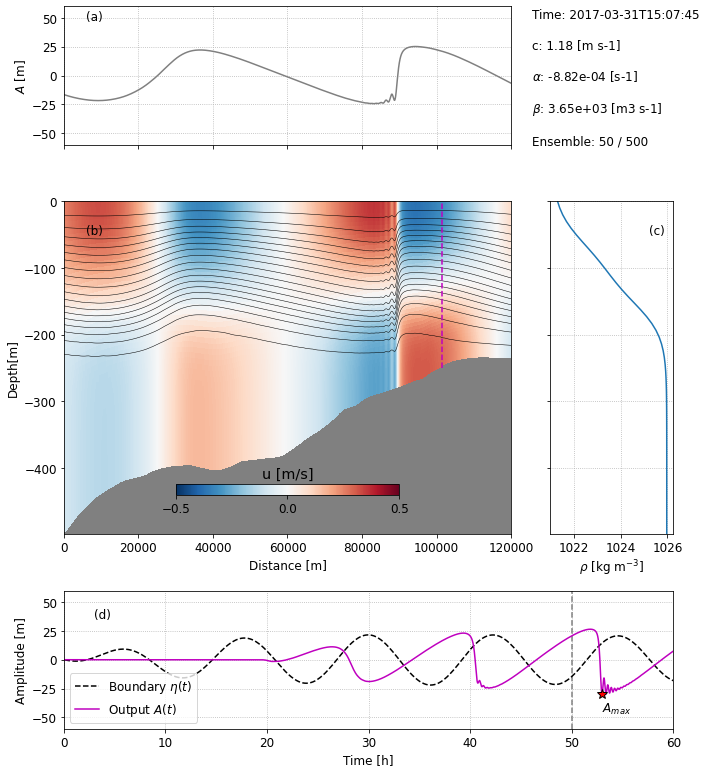

In [13]:
plt.figure(figsize=(10,11))
tstep = 750
plot_scene(mykdv, A_x[tstep,:], tstep, clims=[-0.5, 0.5])

outfile = '../FIGURES/vkdv_snapshot_{}_{}_{}'.format(t0.astype(str)[0:10], sample, tstep)
plt.savefig(outfile+'_v2.png', dpi=150)
plt.savefig(outfile+'_v2.pdf', dpi=150)
outfile